# *(Wang, 2002)* Decision making spiking model

Implementation of the paper: *Wang, Xiao-Jing. "Probabilistic decision making by slow reverberation in cortical circuits." Neuron 36.5 (2002): 955-968.*

- Author : Chaoming Wang (chao.brain@qq.com)

In [7]:
import brainpy as bp
import brainpy.math as bm
from brainpy.dyn import synouts, synapses

import matplotlib.pyplot as plt

## Poisson neurons

In [8]:
class PoissonStim(bp.dyn.NeuGroup):
  def __init__(self, size, freq_mean, freq_var, t_interval, mode=bp.modes.NormalMode()):
    super(PoissonStim, self).__init__(size=size, mode=mode)

    # parameters
    self.freq_mean = freq_mean
    self.freq_var = freq_var
    self.t_interval = t_interval
    self.dt = bm.get_dt() / 1000.

    # variables
    self.freq = bp.init.variable(bm.zeros, mode, 1)
    self.freq_t_last_change = bp.init.variable(lambda s: bm.ones(s) * -1e7, mode, 1)
    self.spike = bp.init.variable(lambda s: bm.zeros(s, dtype=bool), mode, self.varshape)
    self.rng = bm.random.RandomState()

  def reset_state(self, batch_size=None):
    self.freq.value = bp.init.variable(bm.zeros, batch_size, 1)
    self.freq_t_last_change.value = bp.init.variable(lambda s: bm.ones(s) * -1e7, batch_size, 1)
    self.spike.value = bp.init.variable(lambda s: bm.zeros(s, dtype=bool), batch_size, self.varshape)

  def update(self, tdi):
    t, dt = tdi['t'], tdi['dt']
    in_interval = bm.logical_and(pre_stimulus_period < t, t < pre_stimulus_period + stimulus_period)
    in_interval = bm.ones_like(self.freq, dtype=bool) * in_interval
    prev_freq = bm.where(in_interval, self.freq, 0.)
    in_interval = bm.logical_and(in_interval, (t - self.freq_t_last_change) >= self.t_interval)
    self.freq.value = bm.where(in_interval, self.rng.normal(self.freq_mean, self.freq_var, self.freq.shape), prev_freq)
    self.freq_t_last_change.value = bm.where(in_interval, t, self.freq_t_last_change)
    shape = (self.spike.shape[:1] + self.varshape) if isinstance(self.mode, bp.modes.BatchingMode) else self.varshape
    self.spike.value = self.rng.random(shape) < self.freq * self.dt

## Network model

In [9]:
class DecisionMaking(bp.dyn.Network):
  def __init__(self, scale=1., mu0=40., coherence=25.6, f=0.15, mode=bp.modes.NormalMode()):
    super(DecisionMaking, self).__init__()

    num_exc = int(1600 * scale)
    num_inh = int(400 * scale)
    num_A = int(f * num_exc)
    num_B = int(f * num_exc)
    num_N = num_exc - num_A - num_B
    print(f'Total network size: {num_exc + num_inh}')

    poisson_freq = 2400.  # Hz
    w_pos = 1.7
    w_neg = 1. - f * (w_pos - 1.) / (1. - f)
    g_ext2E_AMPA = 2.1  # nS
    g_ext2I_AMPA = 1.62  # nS
    g_E2E_AMPA = 0.05 / scale  # nS
    g_E2I_AMPA = 0.04 / scale  # nS
    g_E2E_NMDA = 0.165 / scale  # nS
    g_E2I_NMDA = 0.13 / scale  # nS
    g_I2E_GABAa = 1.3 / scale  # nS
    g_I2I_GABAa = 1.0 / scale  # nS

    ampa_par = dict(delay_step=int(0.5 / bm.get_dt()), tau=2.0)
    gaba_par = dict(delay_step=int(0.5 / bm.get_dt()), tau=5.0)
    nmda_par = dict(delay_step=int(0.5 / bm.get_dt()), tau_decay=100, tau_rise=2., a=0.5)

    # E neurons/pyramid neurons

    A = bp.neurons.LIF(num_A, V_rest=-70., V_reset=-55., V_th=-50., tau=20., R=0.04,
                       tau_ref=2., V_initializer=bp.init.OneInit(-70.), mode=mode)
    B = bp.neurons.LIF(num_B, V_rest=-70., V_reset=-55., V_th=-50., tau=20., R=0.04,
                       tau_ref=2., V_initializer=bp.init.OneInit(-70.), mode=mode)
    N = bp.neurons.LIF(num_N, V_rest=-70., V_reset=-55., V_th=-50., tau=20., R=0.04,
                       tau_ref=2., V_initializer=bp.init.OneInit(-70.), mode=mode)
    # I neurons/interneurons
    I = bp.neurons.LIF(num_inh, V_rest=-70., V_reset=-55., V_th=-50., tau=10., R=0.05,
                       tau_ref=1., V_initializer=bp.init.OneInit(-70.), mode=mode)

    # poisson stimulus
    IA = PoissonStim(num_A, freq_var=10., t_interval=50., freq_mean=mu0 + mu0 / 100. * coherence, mode=mode)
    IB = PoissonStim(num_B, freq_var=10., t_interval=50., freq_mean=mu0 - mu0 / 100. * coherence, mode=mode)

    # noise neurons
    self.noise_B = bp.neurons.PoissonGroup(num_B, freqs=poisson_freq, mode=mode)
    self.noise_A = bp.neurons.PoissonGroup(num_A, freqs=poisson_freq, mode=mode)
    self.noise_N = bp.neurons.PoissonGroup(num_N, freqs=poisson_freq, mode=mode)
    self.noise_I = bp.neurons.PoissonGroup(num_inh, freqs=poisson_freq, mode=mode)

    # define external inputs
    self.IA2A = synapses.Exponential(IA, A, bp.conn.One2One(), g_max=g_ext2E_AMPA,
                                     mode=mode, output=synouts.COBA(E=0.), **ampa_par)
    self.IB2B = synapses.Exponential(IB, B, bp.conn.One2One(), g_max=g_ext2E_AMPA,
                                     mode=mode, output=synouts.COBA(E=0.), **ampa_par)

    # define E->E/I conn

    self.N2B_AMPA = synapses.Exponential(N, B, bp.conn.All2All(), g_max=g_E2E_AMPA * w_neg,
                                         output=synouts.COBA(E=0.), mode=mode, **ampa_par)
    self.N2A_AMPA = synapses.Exponential(N, A, bp.conn.All2All(), g_max=g_E2E_AMPA * w_neg,
                                         output=synouts.COBA(E=0.), mode=mode, **ampa_par)
    self.N2N_AMPA = synapses.Exponential(N, N, bp.conn.All2All(), g_max=g_E2E_AMPA,
                                         output=synouts.COBA(E=0.), mode=mode, **ampa_par)
    self.N2I_AMPA = synapses.Exponential(N, I, bp.conn.All2All(), g_max=g_E2I_AMPA,
                                         output=synouts.COBA(E=0.), mode=mode, **ampa_par)
    self.N2B_NMDA = synapses.NMDA(N, B, bp.conn.All2All(), g_max=g_E2E_NMDA * w_neg,
                                  output=synouts.MgBlock(E=0., cc_Mg=1.), mode=mode, **nmda_par)
    self.N2A_NMDA = synapses.NMDA(N, A, bp.conn.All2All(), g_max=g_E2E_NMDA * w_neg,
                                  output=synouts.MgBlock(E=0., cc_Mg=1.), mode=mode, **nmda_par)
    self.N2N_NMDA = synapses.NMDA(N, N, bp.conn.All2All(), g_max=g_E2E_NMDA,
                                  output=synouts.MgBlock(E=0., cc_Mg=1.), mode=mode, **nmda_par)
    self.N2I_NMDA = synapses.NMDA(N, I, bp.conn.All2All(), g_max=g_E2I_NMDA,
                                  output=synouts.MgBlock(E=0., cc_Mg=1.), mode=mode, **nmda_par)

    self.B2B_AMPA = synapses.Exponential(B, B, bp.conn.All2All(), g_max=g_E2E_AMPA * w_pos,
                                         output=synouts.COBA(E=0.), mode=mode, **ampa_par)
    self.B2A_AMPA = synapses.Exponential(B, A, bp.conn.All2All(), g_max=g_E2E_AMPA * w_neg,
                                         output=synouts.COBA(E=0.), mode=mode, **ampa_par)
    self.B2N_AMPA = synapses.Exponential(B, N, bp.conn.All2All(), g_max=g_E2E_AMPA,
                                         output=synouts.COBA(E=0.), mode=mode, **ampa_par)
    self.B2I_AMPA = synapses.Exponential(B, I, bp.conn.All2All(), g_max=g_E2I_AMPA,
                                         output=synouts.COBA(E=0.), mode=mode, **ampa_par)
    self.B2B_NMDA = synapses.NMDA(B, B, bp.conn.All2All(), g_max=g_E2E_NMDA * w_pos,
                                  output=synouts.MgBlock(E=0., cc_Mg=1.), mode=mode, **nmda_par)
    self.B2A_NMDA = synapses.NMDA(B, A, bp.conn.All2All(), g_max=g_E2E_NMDA * w_neg,
                                  output=synouts.MgBlock(E=0., cc_Mg=1.), mode=mode, **nmda_par)
    self.B2N_NMDA = synapses.NMDA(B, N, bp.conn.All2All(), g_max=g_E2E_NMDA,
                                  output=synouts.MgBlock(E=0., cc_Mg=1.), mode=mode, **nmda_par)
    self.B2I_NMDA = synapses.NMDA(B, I, bp.conn.All2All(), g_max=g_E2I_NMDA,
                                  output=synouts.MgBlock(E=0., cc_Mg=1.), mode=mode, **nmda_par)

    self.A2B_AMPA = synapses.Exponential(A, B, bp.conn.All2All(), g_max=g_E2E_AMPA * w_neg,
                                         output=synouts.COBA(E=0.), mode=mode, **ampa_par)
    self.A2A_AMPA = synapses.Exponential(A, A, bp.conn.All2All(), g_max=g_E2E_AMPA * w_pos,
                                         output=synouts.COBA(E=0.), mode=mode, **ampa_par)
    self.A2N_AMPA = synapses.Exponential(A, N, bp.conn.All2All(), g_max=g_E2E_AMPA,
                                         output=synouts.COBA(E=0.), mode=mode, **ampa_par)
    self.A2I_AMPA = synapses.Exponential(A, I, bp.conn.All2All(), g_max=g_E2I_AMPA,
                                         output=synouts.COBA(E=0.), mode=mode, **ampa_par)
    self.A2B_NMDA = synapses.NMDA(A, B, bp.conn.All2All(), g_max=g_E2E_NMDA * w_neg,
                                  output=synouts.MgBlock(E=0., cc_Mg=1.), mode=mode, **nmda_par)
    self.A2A_NMDA = synapses.NMDA(A, A, bp.conn.All2All(), g_max=g_E2E_NMDA * w_pos,
                                  output=synouts.MgBlock(E=0., cc_Mg=1.), mode=mode, **nmda_par)
    self.A2N_NMDA = synapses.NMDA(A, N, bp.conn.All2All(), g_max=g_E2E_NMDA,
                                  output=synouts.MgBlock(E=0., cc_Mg=1.), mode=mode, **nmda_par)
    self.A2I_NMDA = synapses.NMDA(A, I, bp.conn.All2All(), g_max=g_E2I_NMDA,
                                  output=synouts.MgBlock(E=0., cc_Mg=1.), mode=mode, **nmda_par)

    # define I->E/I conn
    self.I2B = synapses.Exponential(I, B, bp.conn.All2All(), g_max=g_I2E_GABAa,
                                    output=synouts.COBA(E=-70.), mode=mode, **gaba_par)
    self.I2A = synapses.Exponential(I, A, bp.conn.All2All(), g_max=g_I2E_GABAa,
                                    output=synouts.COBA(E=-70.), mode=mode, **gaba_par)
    self.I2N = synapses.Exponential(I, N, bp.conn.All2All(), g_max=g_I2E_GABAa,
                                    output=synouts.COBA(E=-70.), mode=mode, **gaba_par)
    self.I2I = synapses.Exponential(I, I, bp.conn.All2All(), g_max=g_I2I_GABAa,
                                    output=synouts.COBA(E=-70.), mode=mode, **gaba_par)

    # define external projections
    self.noise2B = synapses.Exponential(self.noise_B, B, bp.conn.One2One(), g_max=g_ext2E_AMPA,
                                        output=synouts.COBA(E=0.), mode=mode, **ampa_par)
    self.noise2A = synapses.Exponential(self.noise_A, A, bp.conn.One2One(), g_max=g_ext2E_AMPA,
                                        output=synouts.COBA(E=0.), mode=mode, **ampa_par)
    self.noise2N = synapses.Exponential(self.noise_N, N, bp.conn.One2One(), g_max=g_ext2E_AMPA,
                                        output=synouts.COBA(E=0.), mode=mode, **ampa_par)
    self.noise2I = synapses.Exponential(self.noise_I, I, bp.conn.One2One(), g_max=g_ext2I_AMPA,
                                        output=synouts.COBA(E=0.), mode=mode, **ampa_par)

    # nodes
    self.B = B
    self.A = A
    self.N = N
    self.I = I
    self.IA = IA
    self.IB = IB

In [10]:
net = DecisionMaking(scale=1.)

Total network size: 2000


## Running

In [11]:
runner = bp.dyn.DSRunner(
  net,
  monitors=['A.spike', 'B.spike', 'IA.freq', 'IB.freq'],
)
pre_stimulus_period = 100.
stimulus_period = 1000.
delay_period = 500.
total_period = pre_stimulus_period + stimulus_period + delay_period
runner.run(total_period)

  0%|          | 0/16000 [00:00<?, ?it/s]

## Visualization

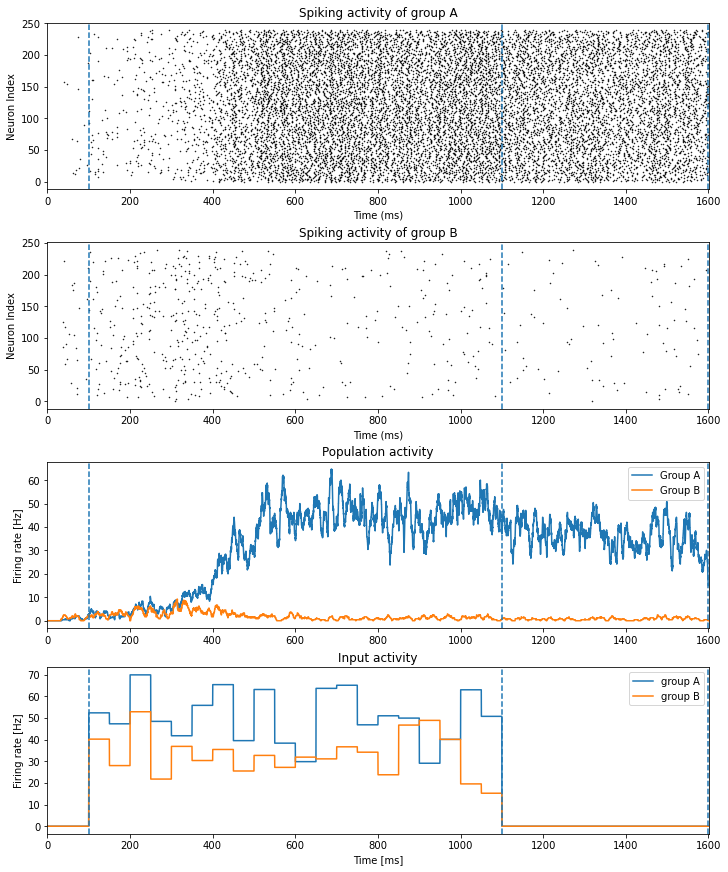

In [12]:
fig, gs = bp.visualize.get_figure(4, 1, 3, 10)

t_start = 0.
fig.add_subplot(gs[0, 0])
bp.visualize.raster_plot(runner.mon.ts, runner.mon['A.spike'], markersize=1)
plt.title("Spiking activity of group A")
plt.ylabel("Neuron Index")
plt.xlim(t_start, total_period + 1)
plt.axvline(pre_stimulus_period, linestyle='dashed')
plt.axvline(pre_stimulus_period + stimulus_period, linestyle='dashed')
plt.axvline(pre_stimulus_period + stimulus_period + delay_period, linestyle='dashed')

fig.add_subplot(gs[1, 0])
bp.visualize.raster_plot(runner.mon.ts, runner.mon['B.spike'], markersize=1)
plt.title("Spiking activity of group B")
plt.ylabel("Neuron Index")
plt.xlim(t_start, total_period + 1)
plt.axvline(pre_stimulus_period, linestyle='dashed')
plt.axvline(pre_stimulus_period + stimulus_period, linestyle='dashed')
plt.axvline(pre_stimulus_period + stimulus_period + delay_period, linestyle='dashed')

fig.add_subplot(gs[2, 0])
rateA = bp.measure.firing_rate(runner.mon['A.spike'], width=10.)
rateB = bp.measure.firing_rate(runner.mon['B.spike'], width=10.)
plt.plot(runner.mon.ts, rateA, label="Group A")
plt.plot(runner.mon.ts, rateB, label="Group B")
plt.ylabel('Firing rate [Hz]')
plt.title("Population activity")
plt.xlim(t_start, total_period + 1)
plt.axvline(pre_stimulus_period, linestyle='dashed')
plt.axvline(pre_stimulus_period + stimulus_period, linestyle='dashed')
plt.axvline(pre_stimulus_period + stimulus_period + delay_period, linestyle='dashed')
plt.legend()

fig.add_subplot(gs[3, 0])
plt.plot(runner.mon.ts, runner.mon['IA.freq'], label="group A")
plt.plot(runner.mon.ts, runner.mon['IB.freq'], label="group B")
plt.title("Input activity")
plt.ylabel("Firing rate [Hz]")
plt.xlim(t_start, total_period + 1)
plt.axvline(pre_stimulus_period, linestyle='dashed')
plt.axvline(pre_stimulus_period + stimulus_period, linestyle='dashed')
plt.axvline(pre_stimulus_period + stimulus_period + delay_period, linestyle='dashed')
plt.legend()

plt.xlabel("Time [ms]")
plt.show()